# Barrier Option Pricing Numerical Simulation Project

Jinsui Liu, Youxuan Li and Zhengyuan Huang

2025/11/24

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, List

from utils import sim_GBM, sim_3over2, sim_options, sim_option, sim_option_with_CI, option_types

## Part 1: Result and Sensitivity Analysis for Black-Scholes Model

### Implement these eight Monte Carlo estimators in Python.

In [2]:
t_grid, S_paths = sim_GBM(r=0.05, sigma=0.2, S0=100, T=1, N=1024, M=10000)
B = np.array([80, 85, 90, 95, 105, 110, 115, 120])

values: Dict[str,List] = {}
for type_str, type_int in option_types.items():
    values[type_str] = []
    for b in B:

        if (b < 100 and type_int % 2 == 0) or (b > 100 and type_int % 2 != 0):
            value = np.nan
        else:
            value = sim_option(S_paths, 100, b, 0.05, 1, type_int)
        # value = sim_option(S_paths, 100, b, 0.05, 1, type_int)
        values[type_str].append(value)

values = pd.DataFrame(values)
values.index = [f"B={b}" for b in B]
values = values.T
print(values.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & B=80 & B=85 & B=90 & B=95 & B=105 & B=110 & B=115 & B=120 \\
\midrule
Up-and-out call & NaN & NaN & NaN & NaN & 0.013362 & 0.131419 & 0.511555 & 1.252354 \\
Down-and-out call & 10.498149 & 10.099318 & 8.937162 & 6.077322 & NaN & NaN & NaN & NaN \\
Up-and-out put & NaN & NaN & NaN & NaN & 2.779609 & 4.183509 & 4.868598 & 5.200089 \\
Down-and-out put & 1.676988 & 0.684303 & 0.160832 & 0.014107 & NaN & NaN & NaN & NaN \\
Up-and-in call & NaN & NaN & NaN & NaN & 10.560438 & 10.442381 & 10.062245 & 9.321446 \\
Down-and-in call & 0.075651 & 0.474482 & 1.636638 & 4.496478 & NaN & NaN & NaN & NaN \\
Up-and-in put & NaN & NaN & NaN & NaN & 2.627550 & 1.223650 & 0.538561 & 0.207071 \\
Down-and-in put & 3.730171 & 4.722856 & 5.246327 & 5.393052 & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



### Sensitivity Analysis w.r.t. $M$

为了满足barrier的初始条件，我们对up-and-xx的期权使用barrier=120， 对down-and-xx的期权使用Barrier=80

In [24]:
prices = {key: np.empty(0) for key in option_types.keys()}
data_M_GBM = {key: {'value': np.empty(0), 'upper': np.empty(0), 'lower': np.empty(0)} for key in option_types.keys()}

for current_m in tqdm(range(1000, 1000001, 1000)):
    t_grid, S_paths = sim_GBM(r=0.05, sigma=0.2, S0=100, T=1, N=252, M=1000)
    for type_str, type_int in option_types.items():
        b = 120 if type_int % 2 == 0 else 80
        values = sim_options(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)
        prices[type_str] = np.append(prices[type_str], values)

        current_mean = prices[type_str].mean()
        data_M_GBM[type_str]['value'] = np.append(data_M_GBM[type_str]['value'], current_mean)
        data_M_GBM[type_str]['upper'] = np.append(data_M_GBM[type_str]['upper'], current_mean + 2.575 * prices[type_str].std()/np.sqrt(len(prices[type_str])))
        data_M_GBM[type_str]['lower'] = np.append(data_M_GBM[type_str]['lower'], current_mean - 2.575 * prices[type_str].std()/np.sqrt(len(prices[type_str])))

100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
C:\Users\31251\AppData\Local\Temp\ipykernel_8072\3677032336.py:14: SyntaxWarning: invalid escape sequence '\l'
  axs[type_int].set_xlabel('$\log_{10} M$')


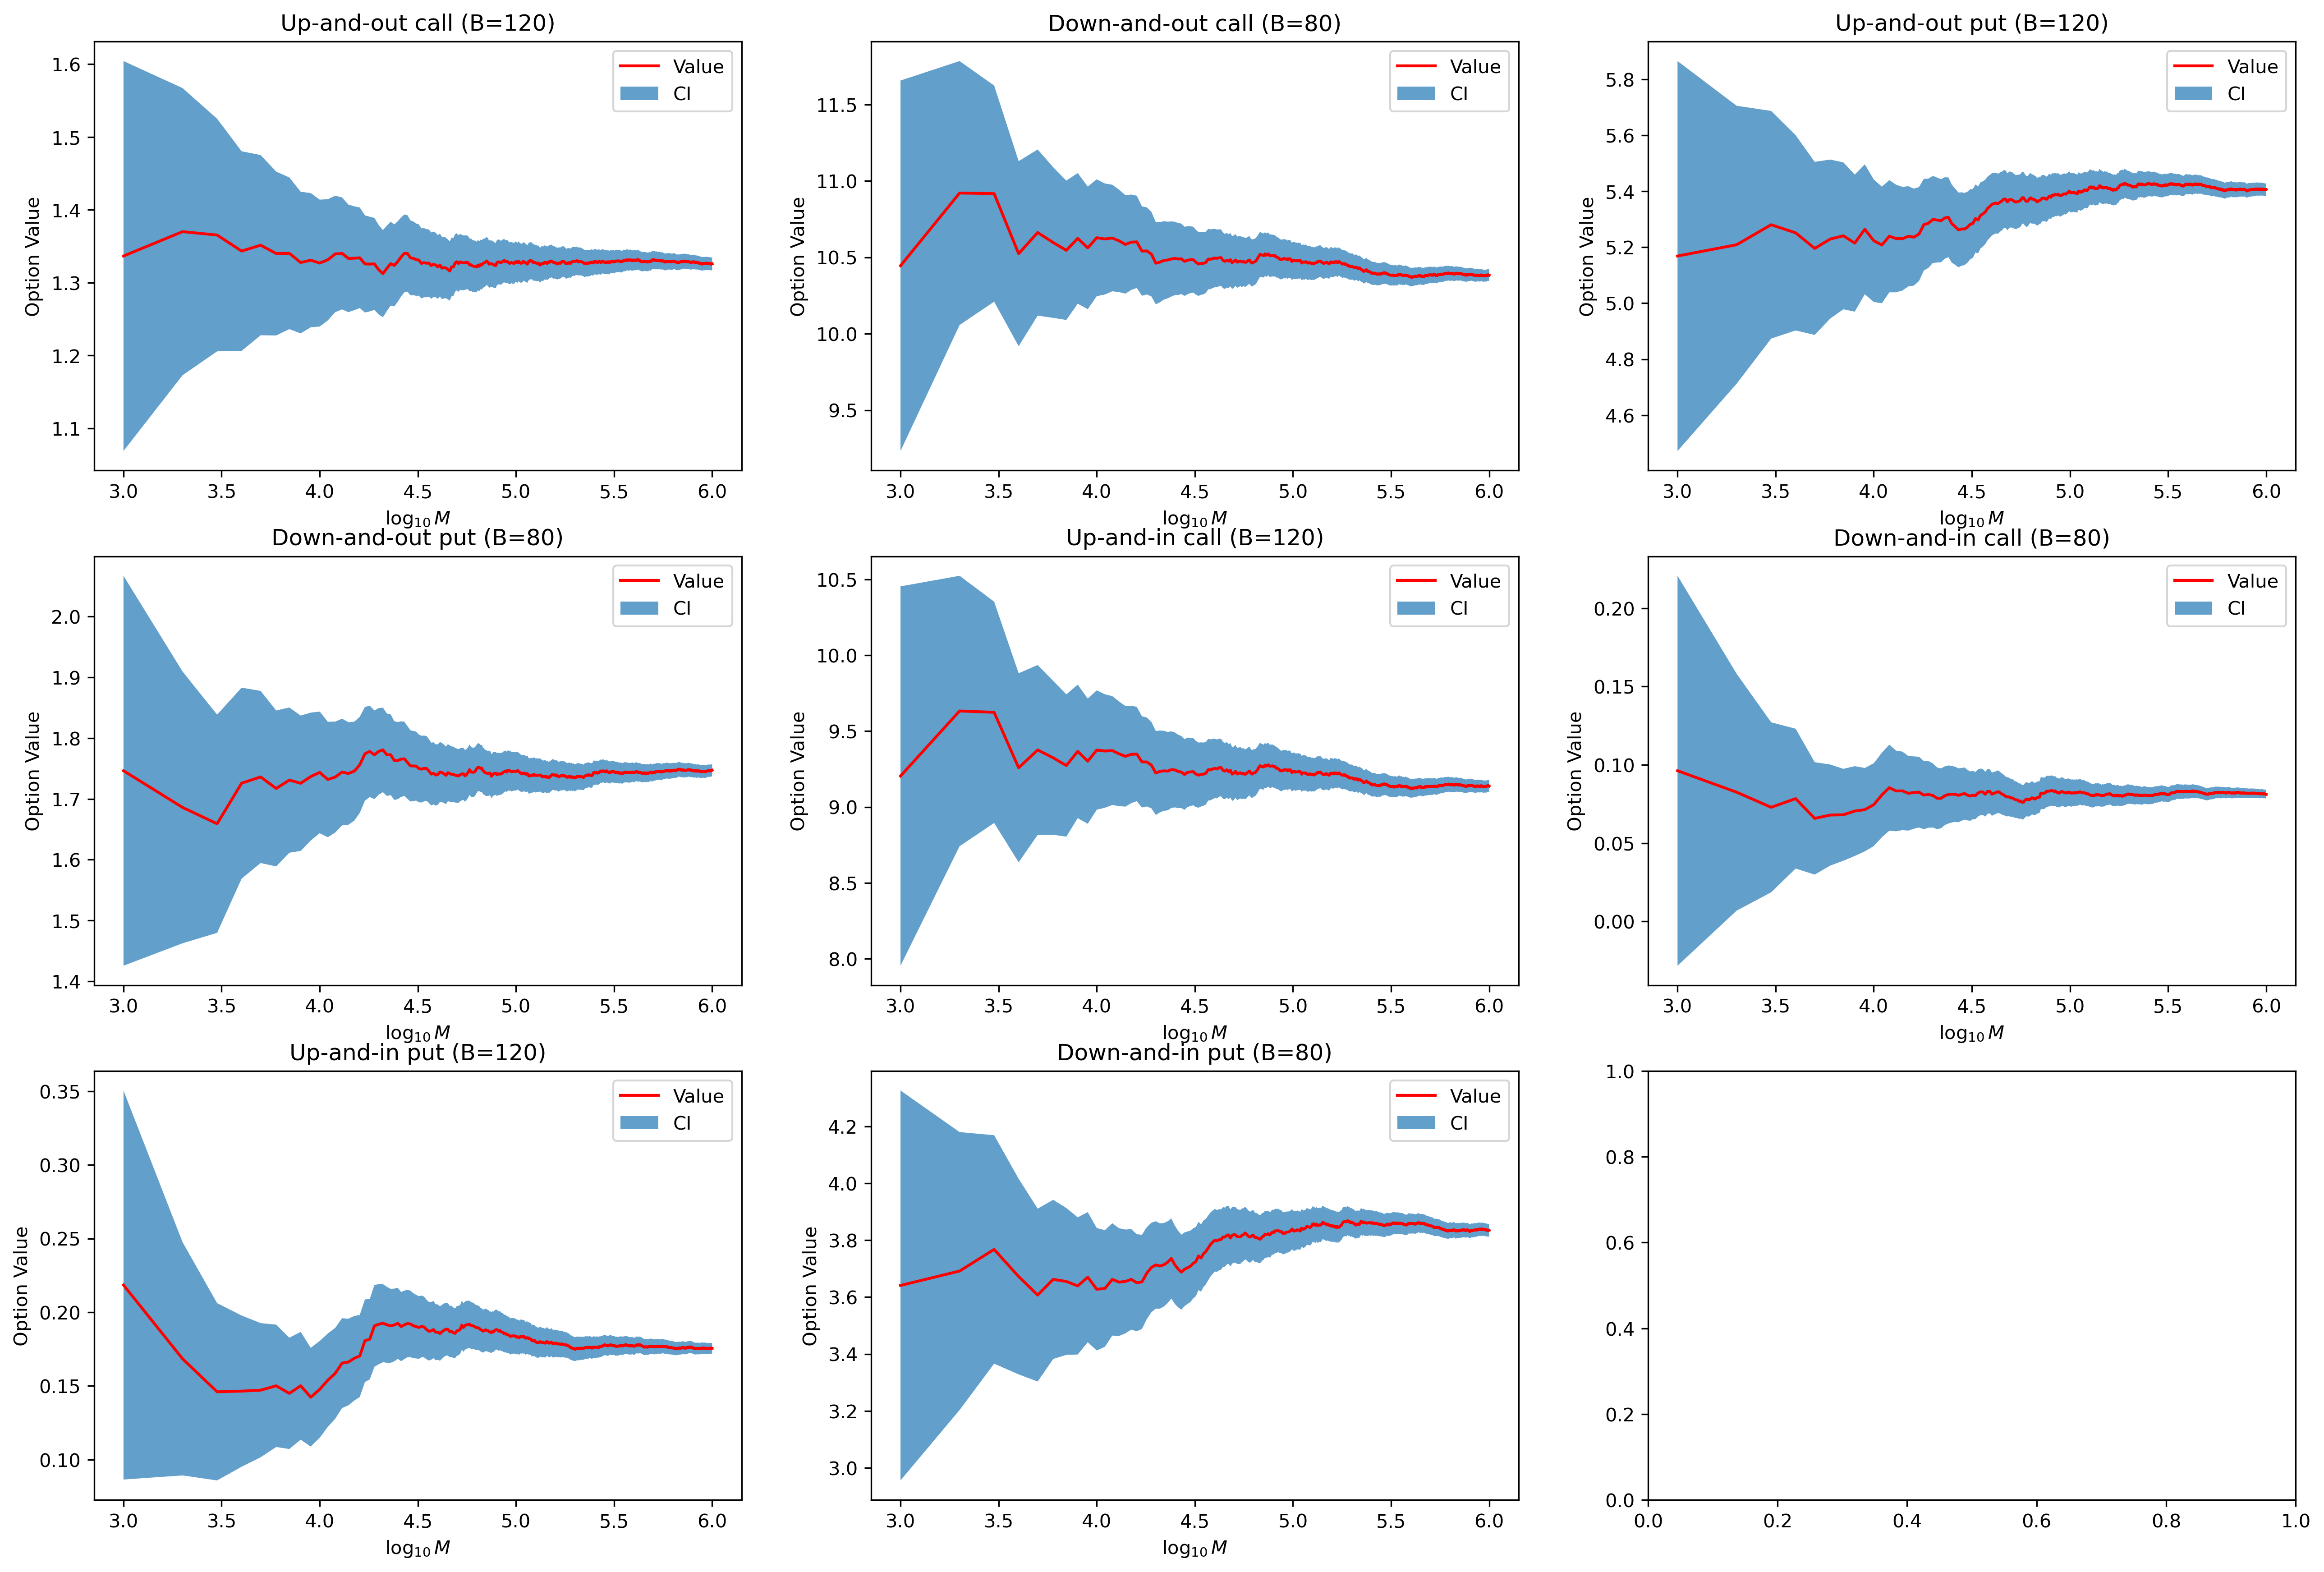

In [25]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

m = np.log10(np.arange(1000, 1000001, 1000))
for type_str, type_int in option_types.items():
    values = np.asarray(data_M_GBM[type_str]['value'])
    upper = np.asarray(data_M_GBM[type_str]['upper'])
    lower = np.asarray(data_M_GBM[type_str]['lower'])

    axs[type_int].plot(m, values, label='Value', c='r')
    axs[type_int].fill_between(m, lower, upper, alpha=0.7, label='CI')

    axs[type_int].set_xlabel('$\log_{10} M$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()

### Sensitivity Analysis w.r.t. $N$

In [16]:
log10N = np.linspace(2,5,20)
figure_data_N = {'xscale': log10N}


for log10n in log10N:
    n = int(10**log10n)
    t_grid, S_paths = sim_GBM(r=0.05, sigma=0.2, S0=100, T=1, N=n, M=10000)
    for type_str, type_int in option_types.items():
        if not type_str in figure_data_N:
            figure_data_N[type_str] = {'value': [], 'CI': []}

        b = 120 if type_int % 2 == 0 else 80
        value, CI = sim_option_with_CI(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)

        figure_data_N[type_str]['value'].append(value)
        figure_data_N[type_str]['CI'].append(CI)

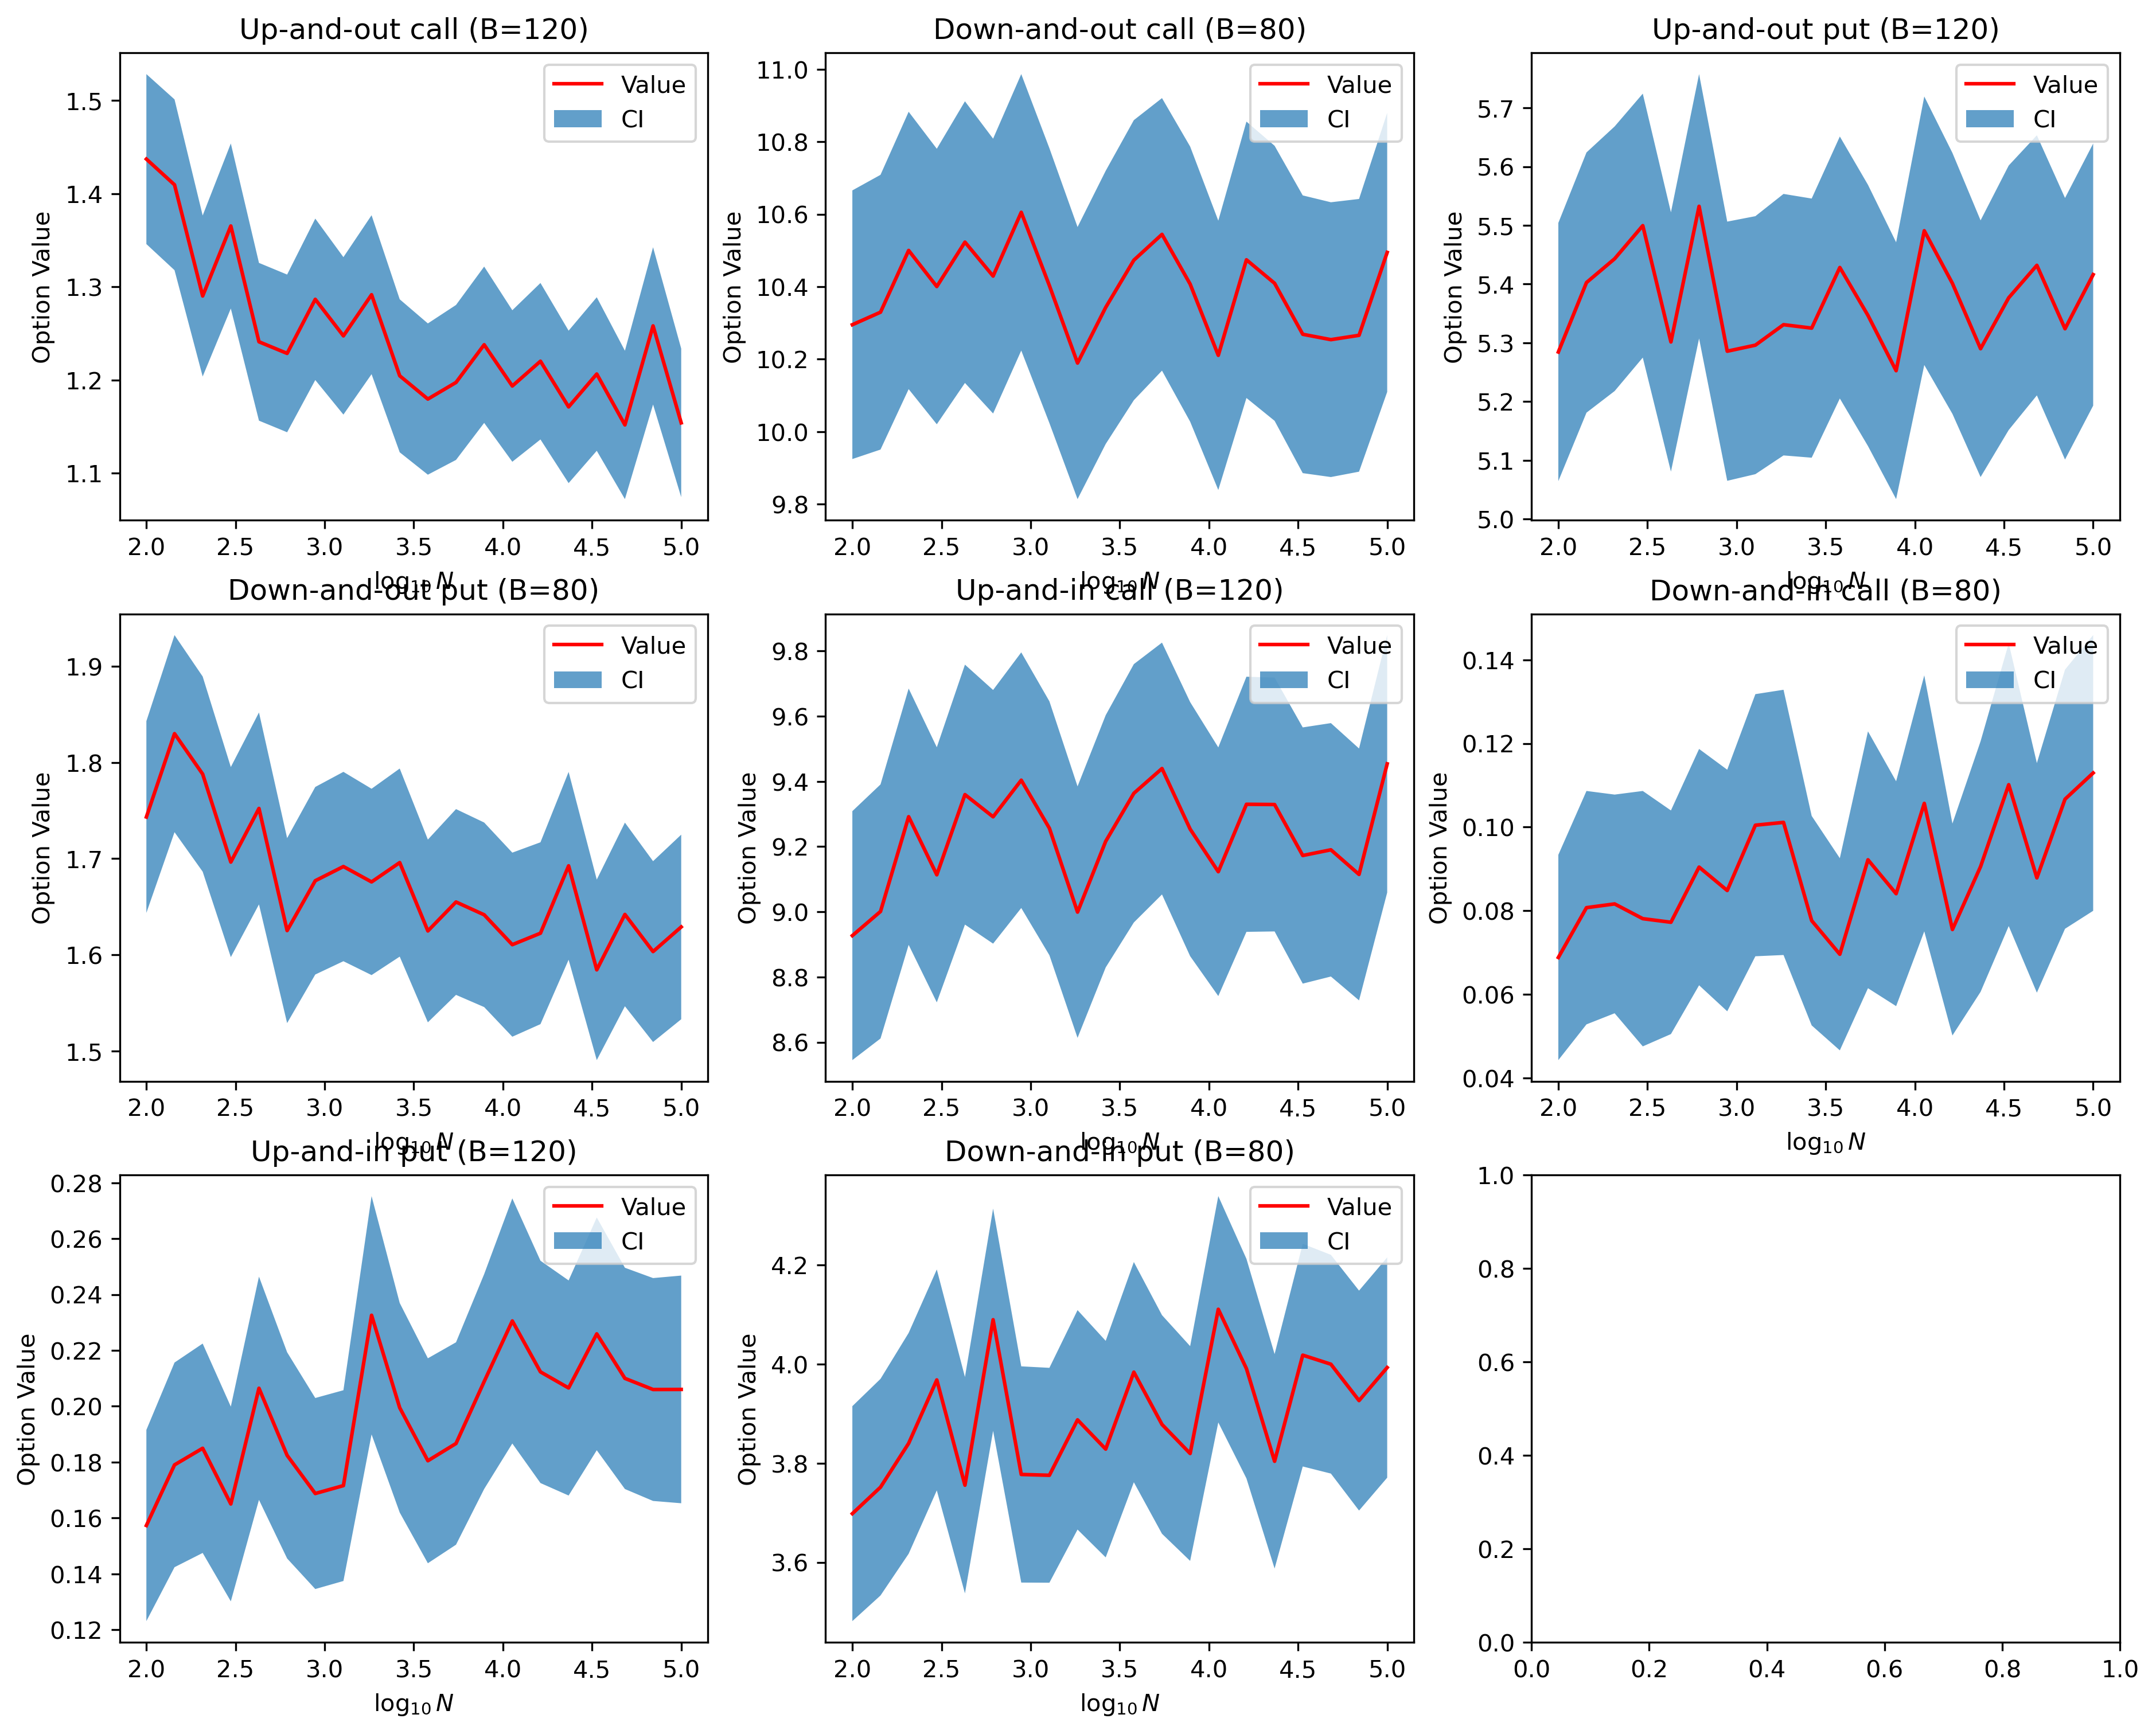

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

n = figure_data_N['xscale']
for type_str, type_int in option_types.items():
    values = np.asarray(figure_data_N[type_str]['value'])
    CI = np.asarray(figure_data_N[type_str]['CI']).T

    axs[type_int].plot(n, values, label='Value', c='r')
    axs[type_int].fill_between(n, CI[0], CI[1], alpha=0.7, label='CI')

    axs[type_int].set_xlabel('$\log_{10} N$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()

## Part 2: Result and Sensitivity Analysis for 3/2 Stochastic Model

### Implement these eight Monte Carlo estimators in Python.

In [6]:
t_grid, _, S_paths = sim_3over2(r=0.05, theta=0.2, kappa=0.2, lbd=0.67, rho=-0.5, S0=100, V0=0.2, T=1, N=1024, M=10000)
B = np.array([80, 85, 90, 95, 105, 110, 115, 120])

values: Dict[str,List] = {}
for type_str, type_int in option_types.items():
    values[type_str] = []
    for b in B:

        if (b < 100 and type_int % 2 == 0) or (b > 100 and type_int % 2 != 0):
            value = np.nan
        else:
            value = sim_option(S_paths, 100, b, 0.05, 1, type_int)
        # value = sim_option(S_paths, 100, b, 0.05, 1, type_int)
        values[type_str].append(value)

values = pd.DataFrame(values)
values.index = [f"B={b}" for b in B]
values = values.T
print(values.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & B=80 & B=85 & B=90 & B=95 & B=105 & B=110 & B=115 & B=120 \\
\midrule
Up-and-out call & NaN & NaN & NaN & NaN & 0.000930 & 0.015106 & 0.072269 & 0.179615 \\
Down-and-out call & 15.995642 & 13.505186 & 10.417749 & 6.188067 & NaN & NaN & NaN & NaN \\
Up-and-out put & NaN & NaN & NaN & NaN & 4.364659 & 7.083897 & 9.075394 & 10.641661 \\
Down-and-out put & 0.318190 & 0.104475 & 0.019515 & 0.003051 & NaN & NaN & NaN & NaN \\
Up-and-in call & NaN & NaN & NaN & NaN & 19.686141 & 19.671965 & 19.614802 & 19.507456 \\
Down-and-in call & 3.691429 & 6.181886 & 9.269322 & 13.499005 & NaN & NaN & NaN & NaN \\
Up-and-in put & NaN & NaN & NaN & NaN & 10.478534 & 7.759295 & 5.767798 & 4.201531 \\
Down-and-in put & 14.525003 & 14.738717 & 14.823677 & 14.840142 & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



### Sensitivity Analysis w.r.t. $M$

为了满足barrier的初始条件，我们对up-and-xx的期权使用barrier=120， 对down-and-xx的期权使用Barrier=80

In [2]:
prices = {key: np.empty(0) for key in option_types.keys()}
data_M_3over2 = {key: {'value': np.empty(0), 'upper': np.empty(0), 'lower': np.empty(0)} for key in option_types.keys()}

for current_m in tqdm(range(1000, 1000001, 1000)):
    t_grid, _, S_paths = sim_3over2(r=0.05, theta=0.2, kappa=0.2, lbd=0.67, rho=-0.5, S0=100, V0=0.2, T=1, N=252, M=1000)
    for type_str, type_int in option_types.items():
        b = 120 if type_int % 2 == 0 else 80
        values = sim_options(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)
        prices[type_str] = np.append(prices[type_str], values)

        current_mean = prices[type_str].mean()
        data_M_3over2[type_str]['value'] = np.append(data_M_3over2[type_str]['value'], current_mean)
        data_M_3over2[type_str]['upper'] = np.append(data_M_3over2[type_str]['upper'], current_mean + 2.575 * prices[type_str].std()/np.sqrt(len(prices[type_str])))
        data_M_3over2[type_str]['lower'] = np.append(data_M_3over2[type_str]['lower'], current_mean - 2.575 * prices[type_str].std()/np.sqrt(len(prices[type_str])))

100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


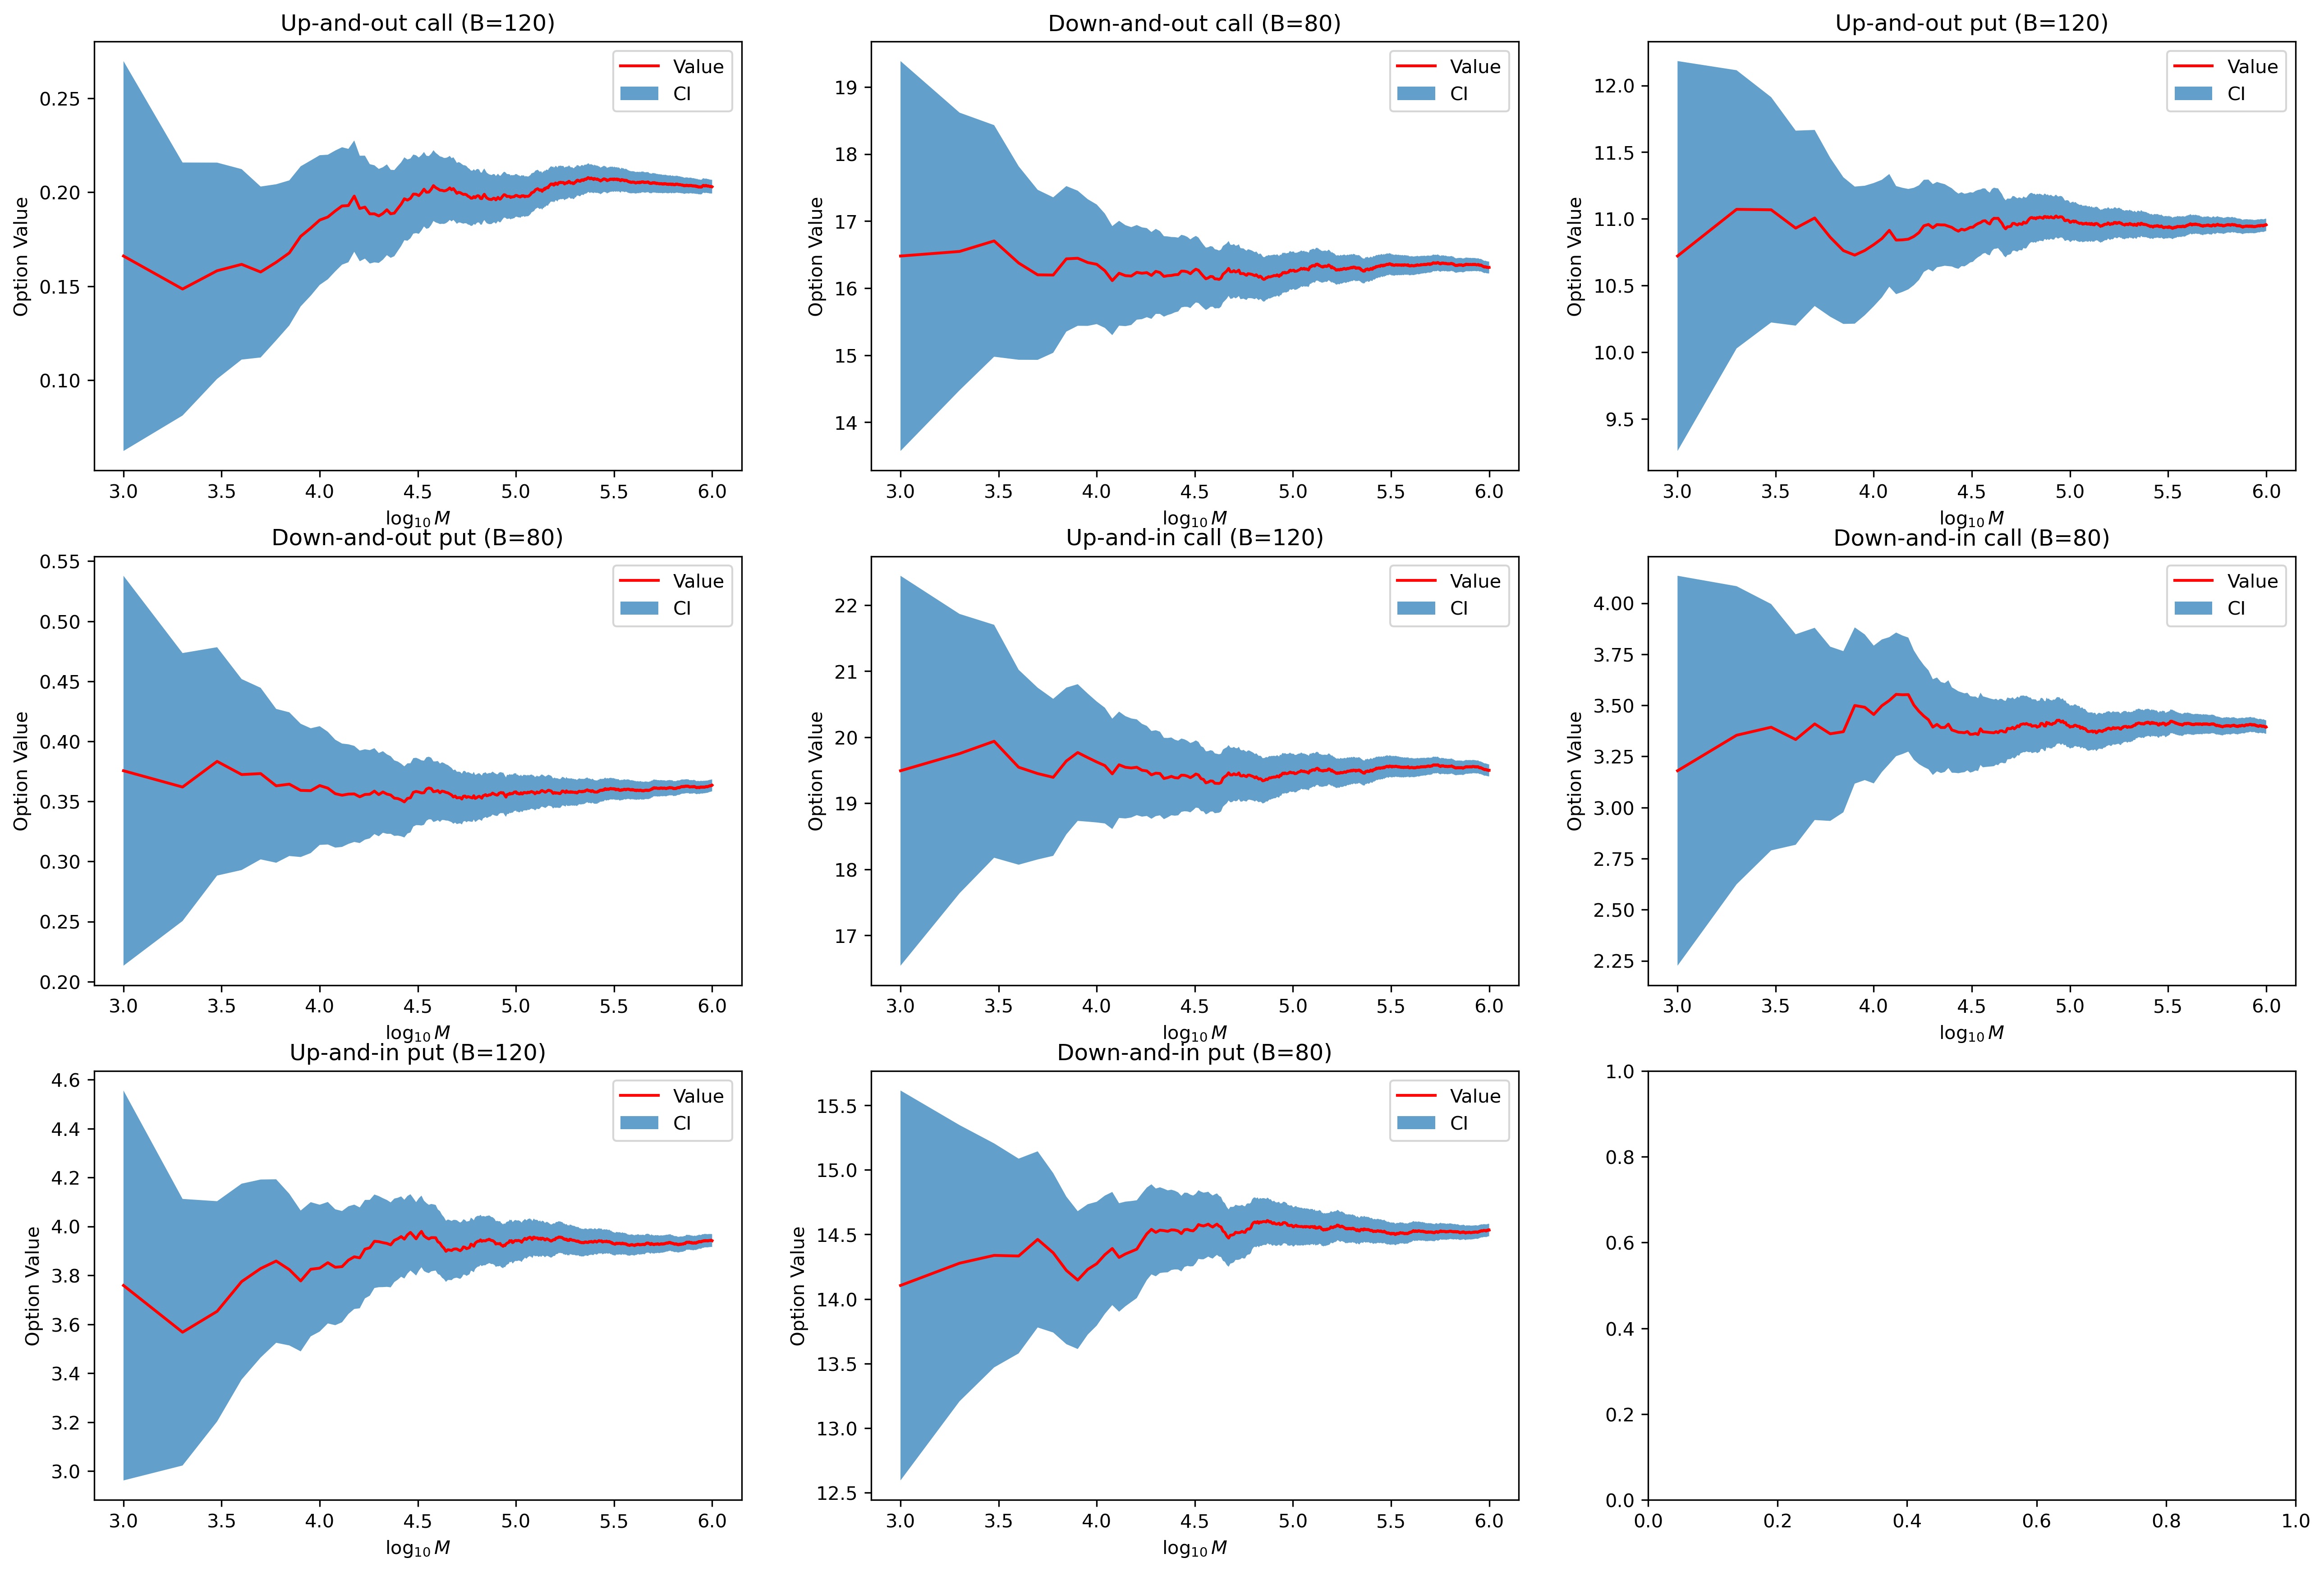

In [6]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

m = np.log10(np.arange(1000, 1000001, 1000))
for type_str, type_int in option_types.items():
    values = np.asarray(data_M_3over2[type_str]['value'])
    upper = np.asarray(data_M_3over2[type_str]['upper'])
    lower = np.asarray(data_M_3over2[type_str]['lower'])

    axs[type_int].plot(m, values, label='Value', c='r')
    axs[type_int].fill_between(m, lower, upper, alpha=0.7, label='CI')

    axs[type_int].set_xlabel('$\\log_{10} M$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()

### Sensitivity Analysis w.r.t. $N$

In [4]:
data_N_3over2 = {key: {'value': np.empty(0), 'upper': np.empty(0), 'lower': np.empty(0)} for key in option_types.keys()}

for current_n in tqdm((10**np.linspace(2,5,20)).astype(int)):
    t_grid, _, S_paths = sim_3over2(r=0.05, theta=0.2, kappa=0.2, lbd=0.67, rho=-0.5, S0=100, V0=0.2, T=1, N=current_n, M=10000)
    for type_str, type_int in option_types.items():
        b = 120 if type_int % 2 == 0 else 80
        value, CI = sim_option_with_CI(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)

        data_N_3over2[type_str]['value'] = np.append(data_N_3over2[type_str]['value'], value)
        data_N_3over2[type_str]['upper'] = np.append(data_N_3over2[type_str]['upper'], CI[0])
        data_N_3over2[type_str]['lower'] = np.append(data_N_3over2[type_str]['lower'], CI[1])

100%|██████████| 20/20 [10:27<00:00, 31.35s/it] 


<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
C:\Users\31251\AppData\Local\Temp\ipykernel_8072\3746966865.py:14: SyntaxWarning: invalid escape sequence '\l'
  axs[type_int].set_xlabel('$\log_{10} N$')


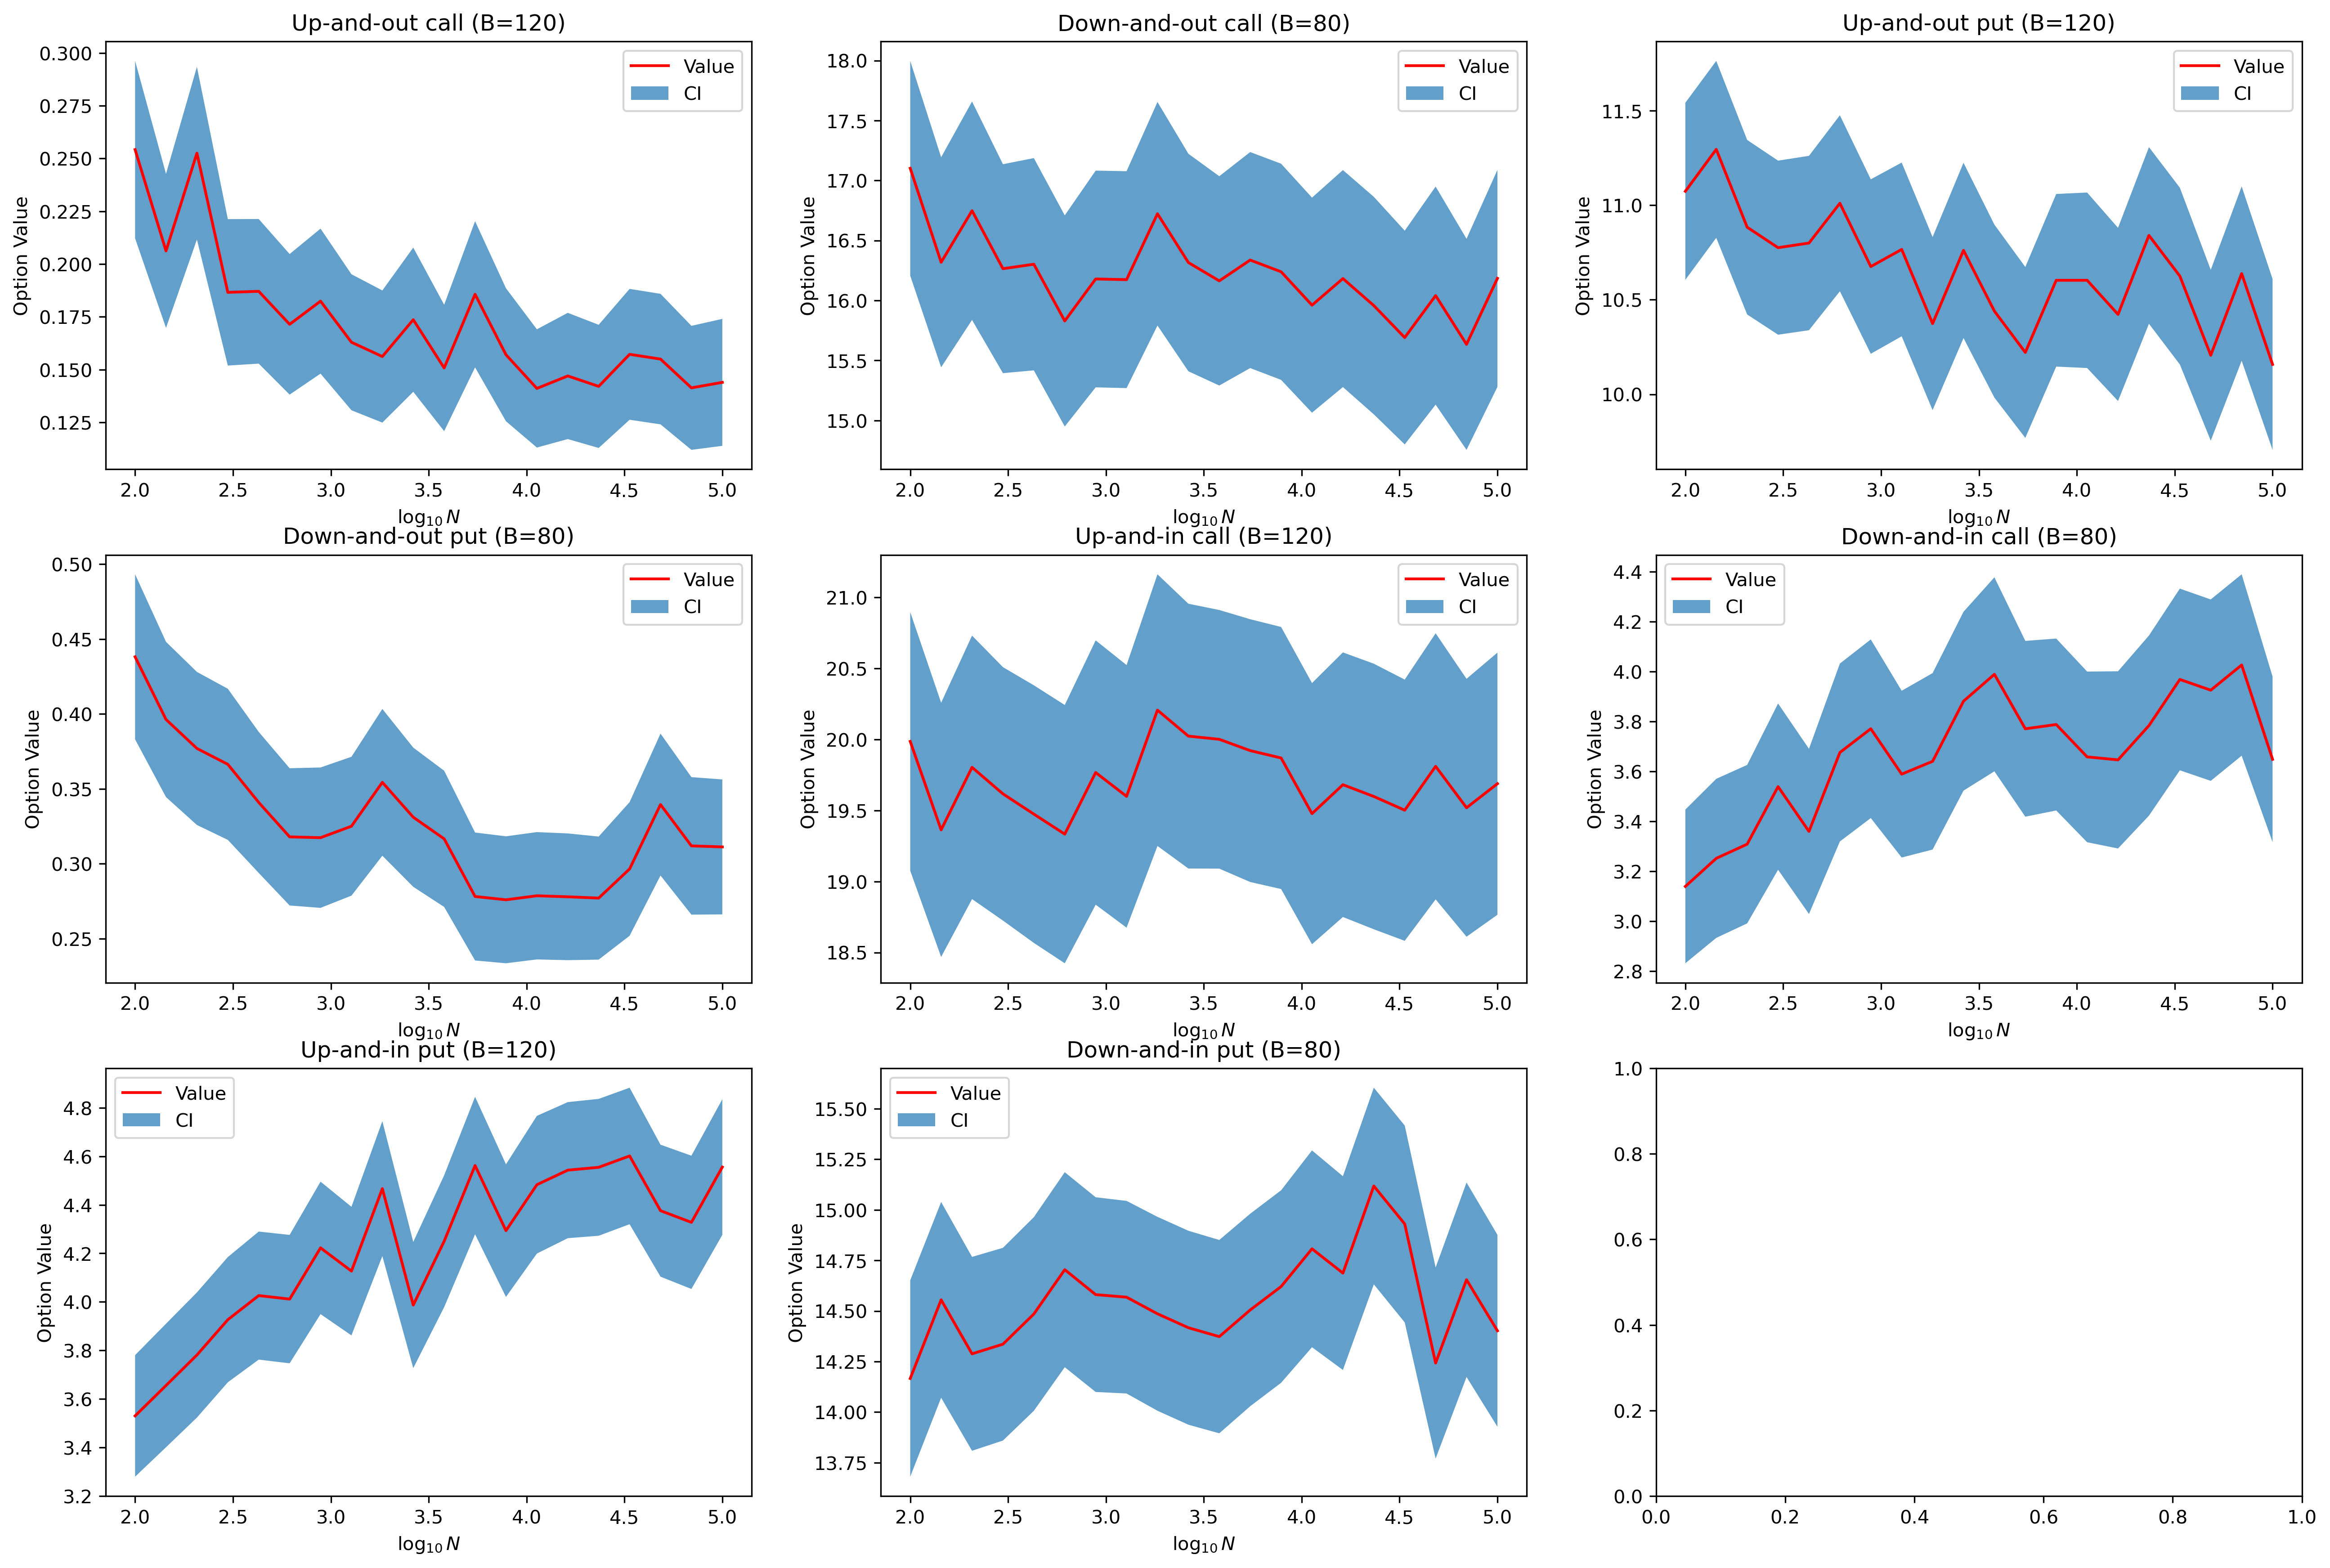

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

n = np.linspace(2,5,20)
for type_str, type_int in option_types.items():
    values = np.asarray(data_N_3over2[type_str]['value'])
    upper = np.asarray(data_N_3over2[type_str]['upper'])
    lower = np.asarray(data_N_3over2[type_str]['lower'])

    axs[type_int].plot(n, values, label='Value', c='r')
    axs[type_int].fill_between(n, lower, upper, alpha=0.7, label='CI')

    axs[type_int].set_xlabel('$\\log_{10} N$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()

### Sensitivity Analysis w.r.t. $\lambda$

In [7]:
data_lbd_3over2 = {key: {'value': np.empty(0), 'upper': np.empty(0), 'lower': np.empty(0)} for key in option_types.keys()}

for lbd in tqdm(np.linspace(0.1, 1, 20)):
    t_grid, _, S_paths = sim_3over2(r=0.05, theta=0.2, kappa=0.2, lbd=lbd, rho=-0.5, S0=100, V0=0.2, T=1, N=252, M=100000)
    for type_str, type_int in option_types.items():
        b = 120 if type_int % 2 == 0 else 80
        value, CI = sim_option_with_CI(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)

        data_lbd_3over2[type_str]['value'] = np.append(data_lbd_3over2[type_str]['value'], value)
        data_lbd_3over2[type_str]['upper'] = np.append(data_lbd_3over2[type_str]['upper'], CI[0])
        data_lbd_3over2[type_str]['lower'] = np.append(data_lbd_3over2[type_str]['lower'], CI[1])

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


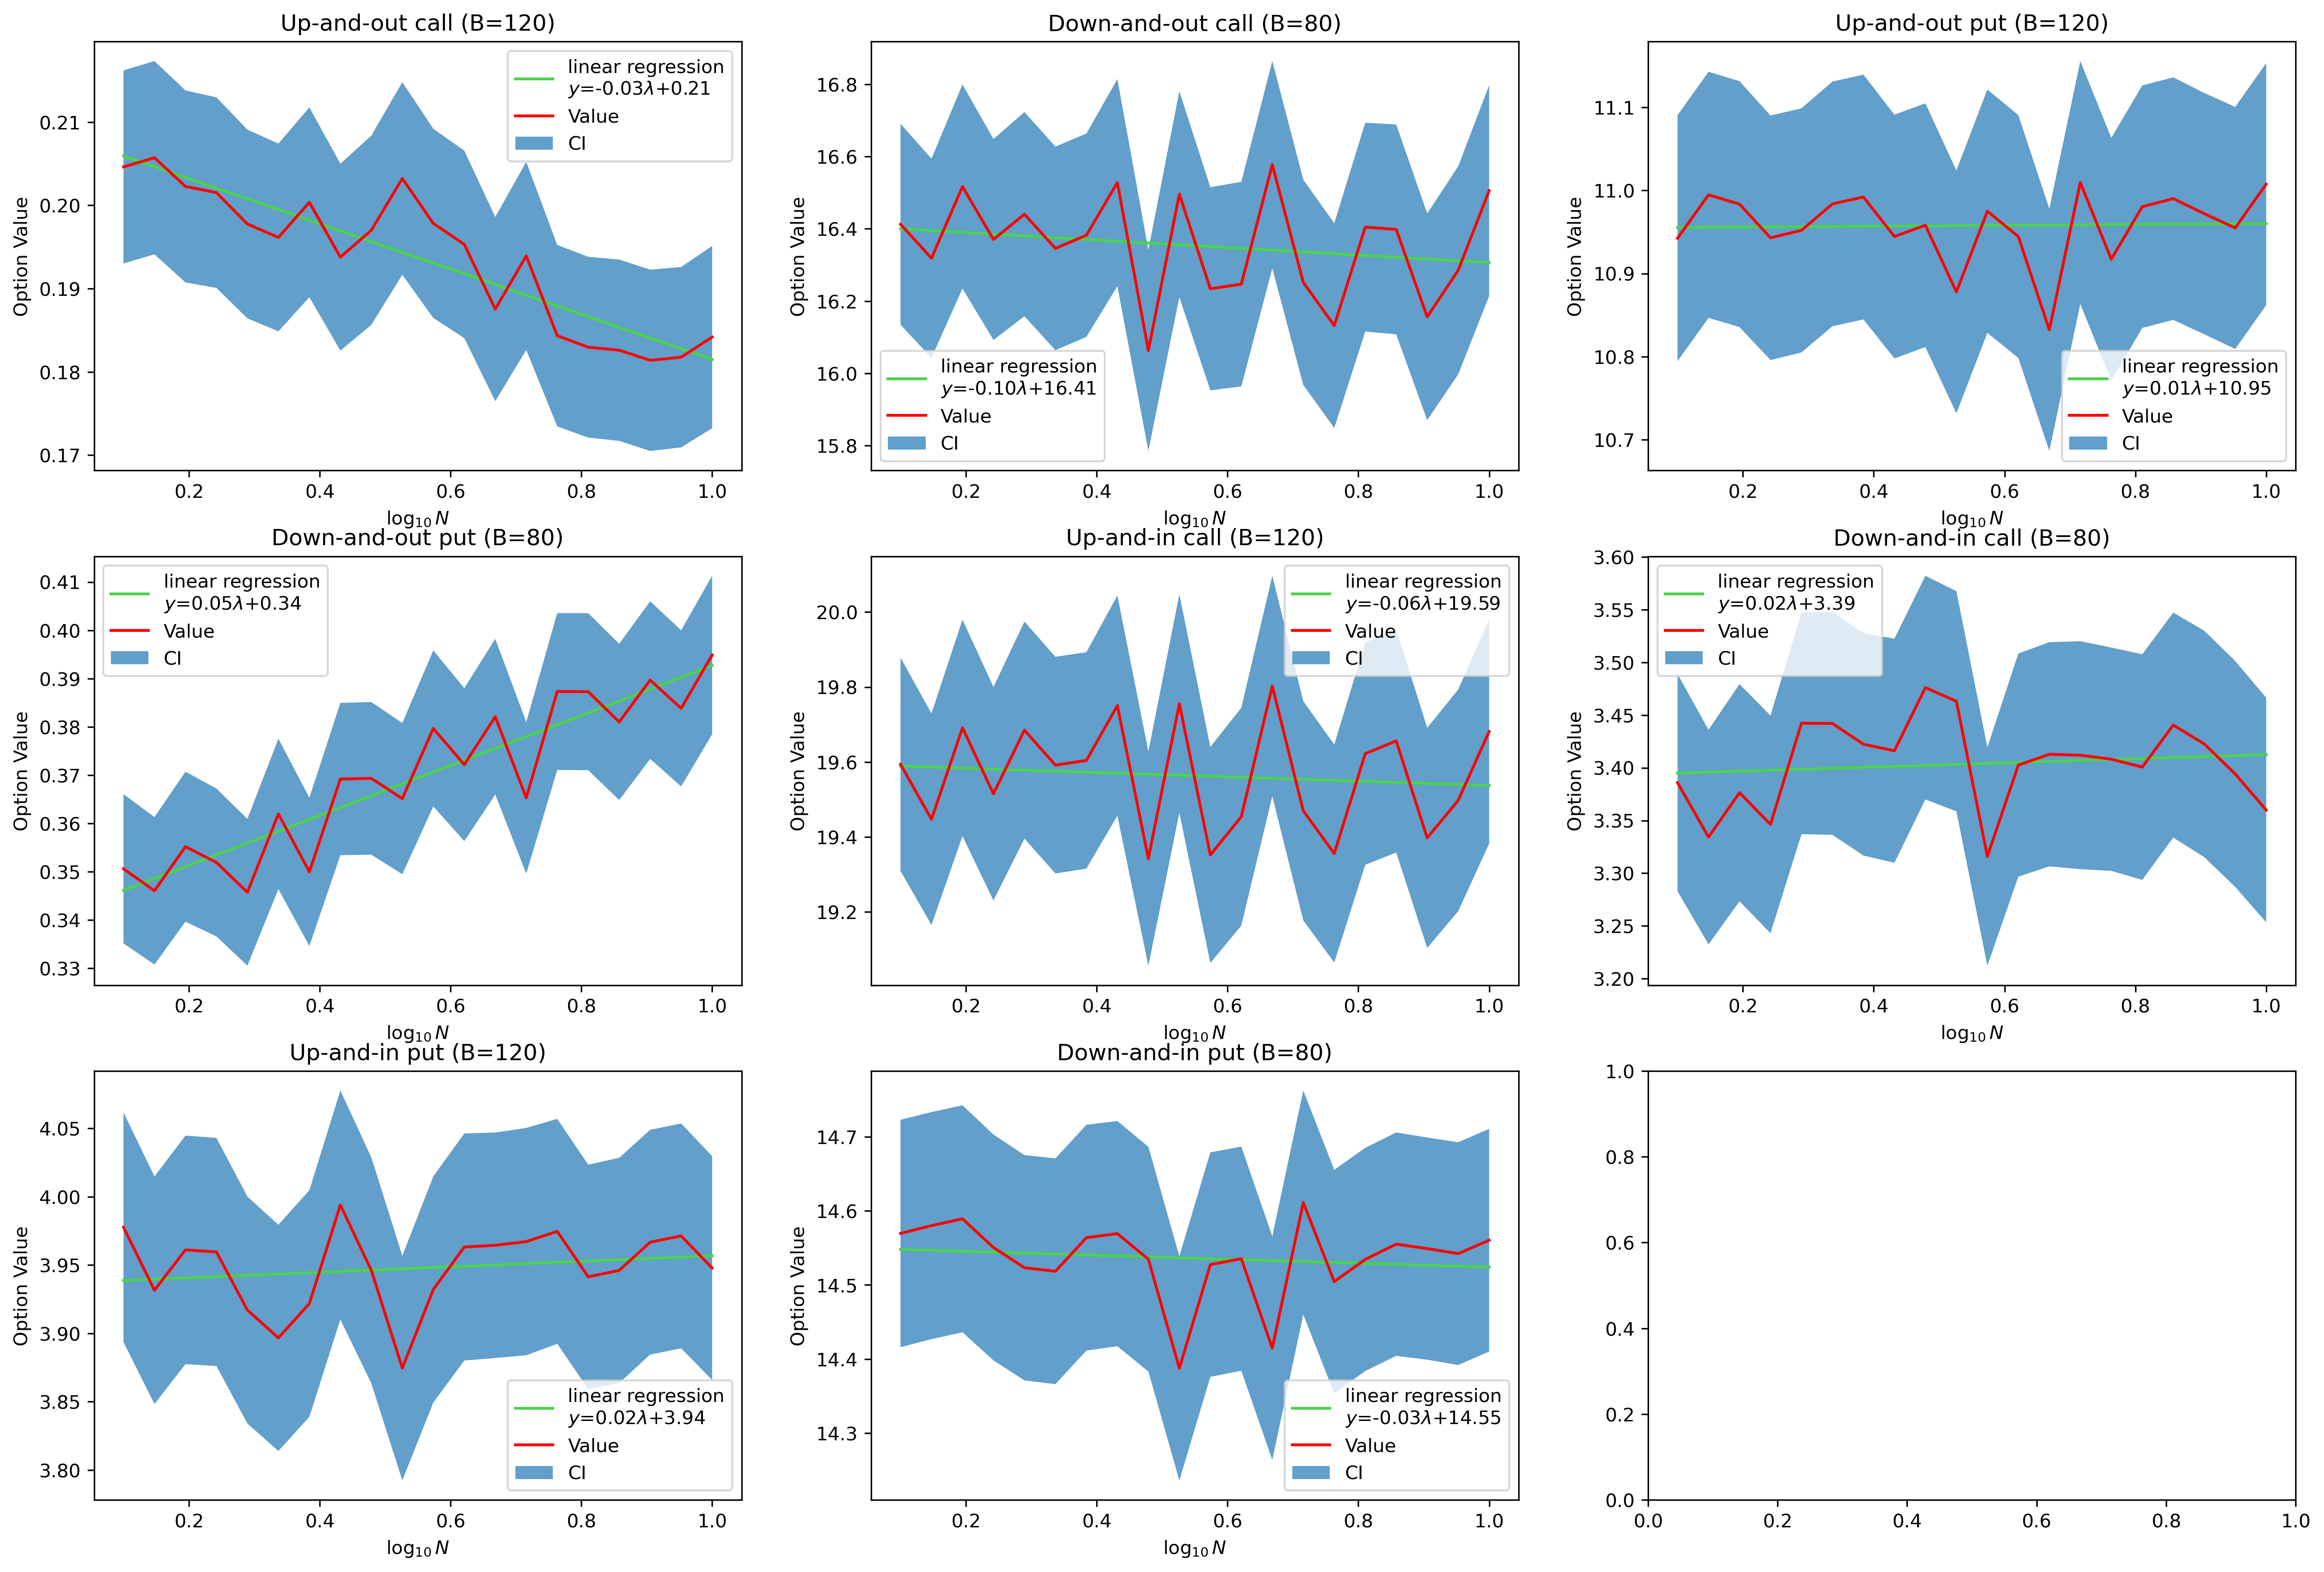

In [22]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

lbd = np.linspace(0.1, 1, 20)
for type_str, type_int in option_types.items():
    values = np.asarray(data_lbd_3over2[type_str]['value'])
    upper = np.asarray(data_lbd_3over2[type_str]['upper'])
    lower = np.asarray(data_lbd_3over2[type_str]['lower'])

    b1, b0 = np.polyfit(lbd, values, deg=1)
    axs[type_int].plot(lbd, b0 + b1 * lbd, c="#4bd34b", label=f'linear regression\n$y$={b1:.02f}$\\lambda$+{b0:.02f}')

    axs[type_int].plot(lbd, values, label='Value', c='r')
    axs[type_int].fill_between(lbd, lower, upper, alpha=0.7, label='CI')
    

    axs[type_int].set_xlabel('$\\log_{10} N$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()

### Sensitivity Analysis w.r.t. $\rho$

In [17]:
data_lbd_3over2 = {key: {'value': np.empty(0), 'upper': np.empty(0), 'lower': np.empty(0)} for key in option_types.keys()}

for rho in tqdm(np.linspace(-0.99, 0.99, 20)):
    t_grid, _, S_paths = sim_3over2(r=0.05, theta=0.2, kappa=0.2, lbd=0.67, rho=rho, S0=100, V0=0.2, T=1, N=252, M=100000)
    for type_str, type_int in option_types.items():
        b = 120 if type_int % 2 == 0 else 80
        value, CI = sim_option_with_CI(S_paths, K=100, B=b, r=0.05, T=1, option_type=type_int)

        data_lbd_3over2[type_str]['value'] = np.append(data_lbd_3over2[type_str]['value'], value)
        data_lbd_3over2[type_str]['upper'] = np.append(data_lbd_3over2[type_str]['upper'], CI[0])
        data_lbd_3over2[type_str]['lower'] = np.append(data_lbd_3over2[type_str]['lower'], CI[1])

100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
C:\Users\31251\AppData\Local\Temp\ipykernel_8072\1179332456.py:17: SyntaxWarning: invalid escape sequence '\l'
  axs[type_int].set_xlabel('$\log_{10} N$')


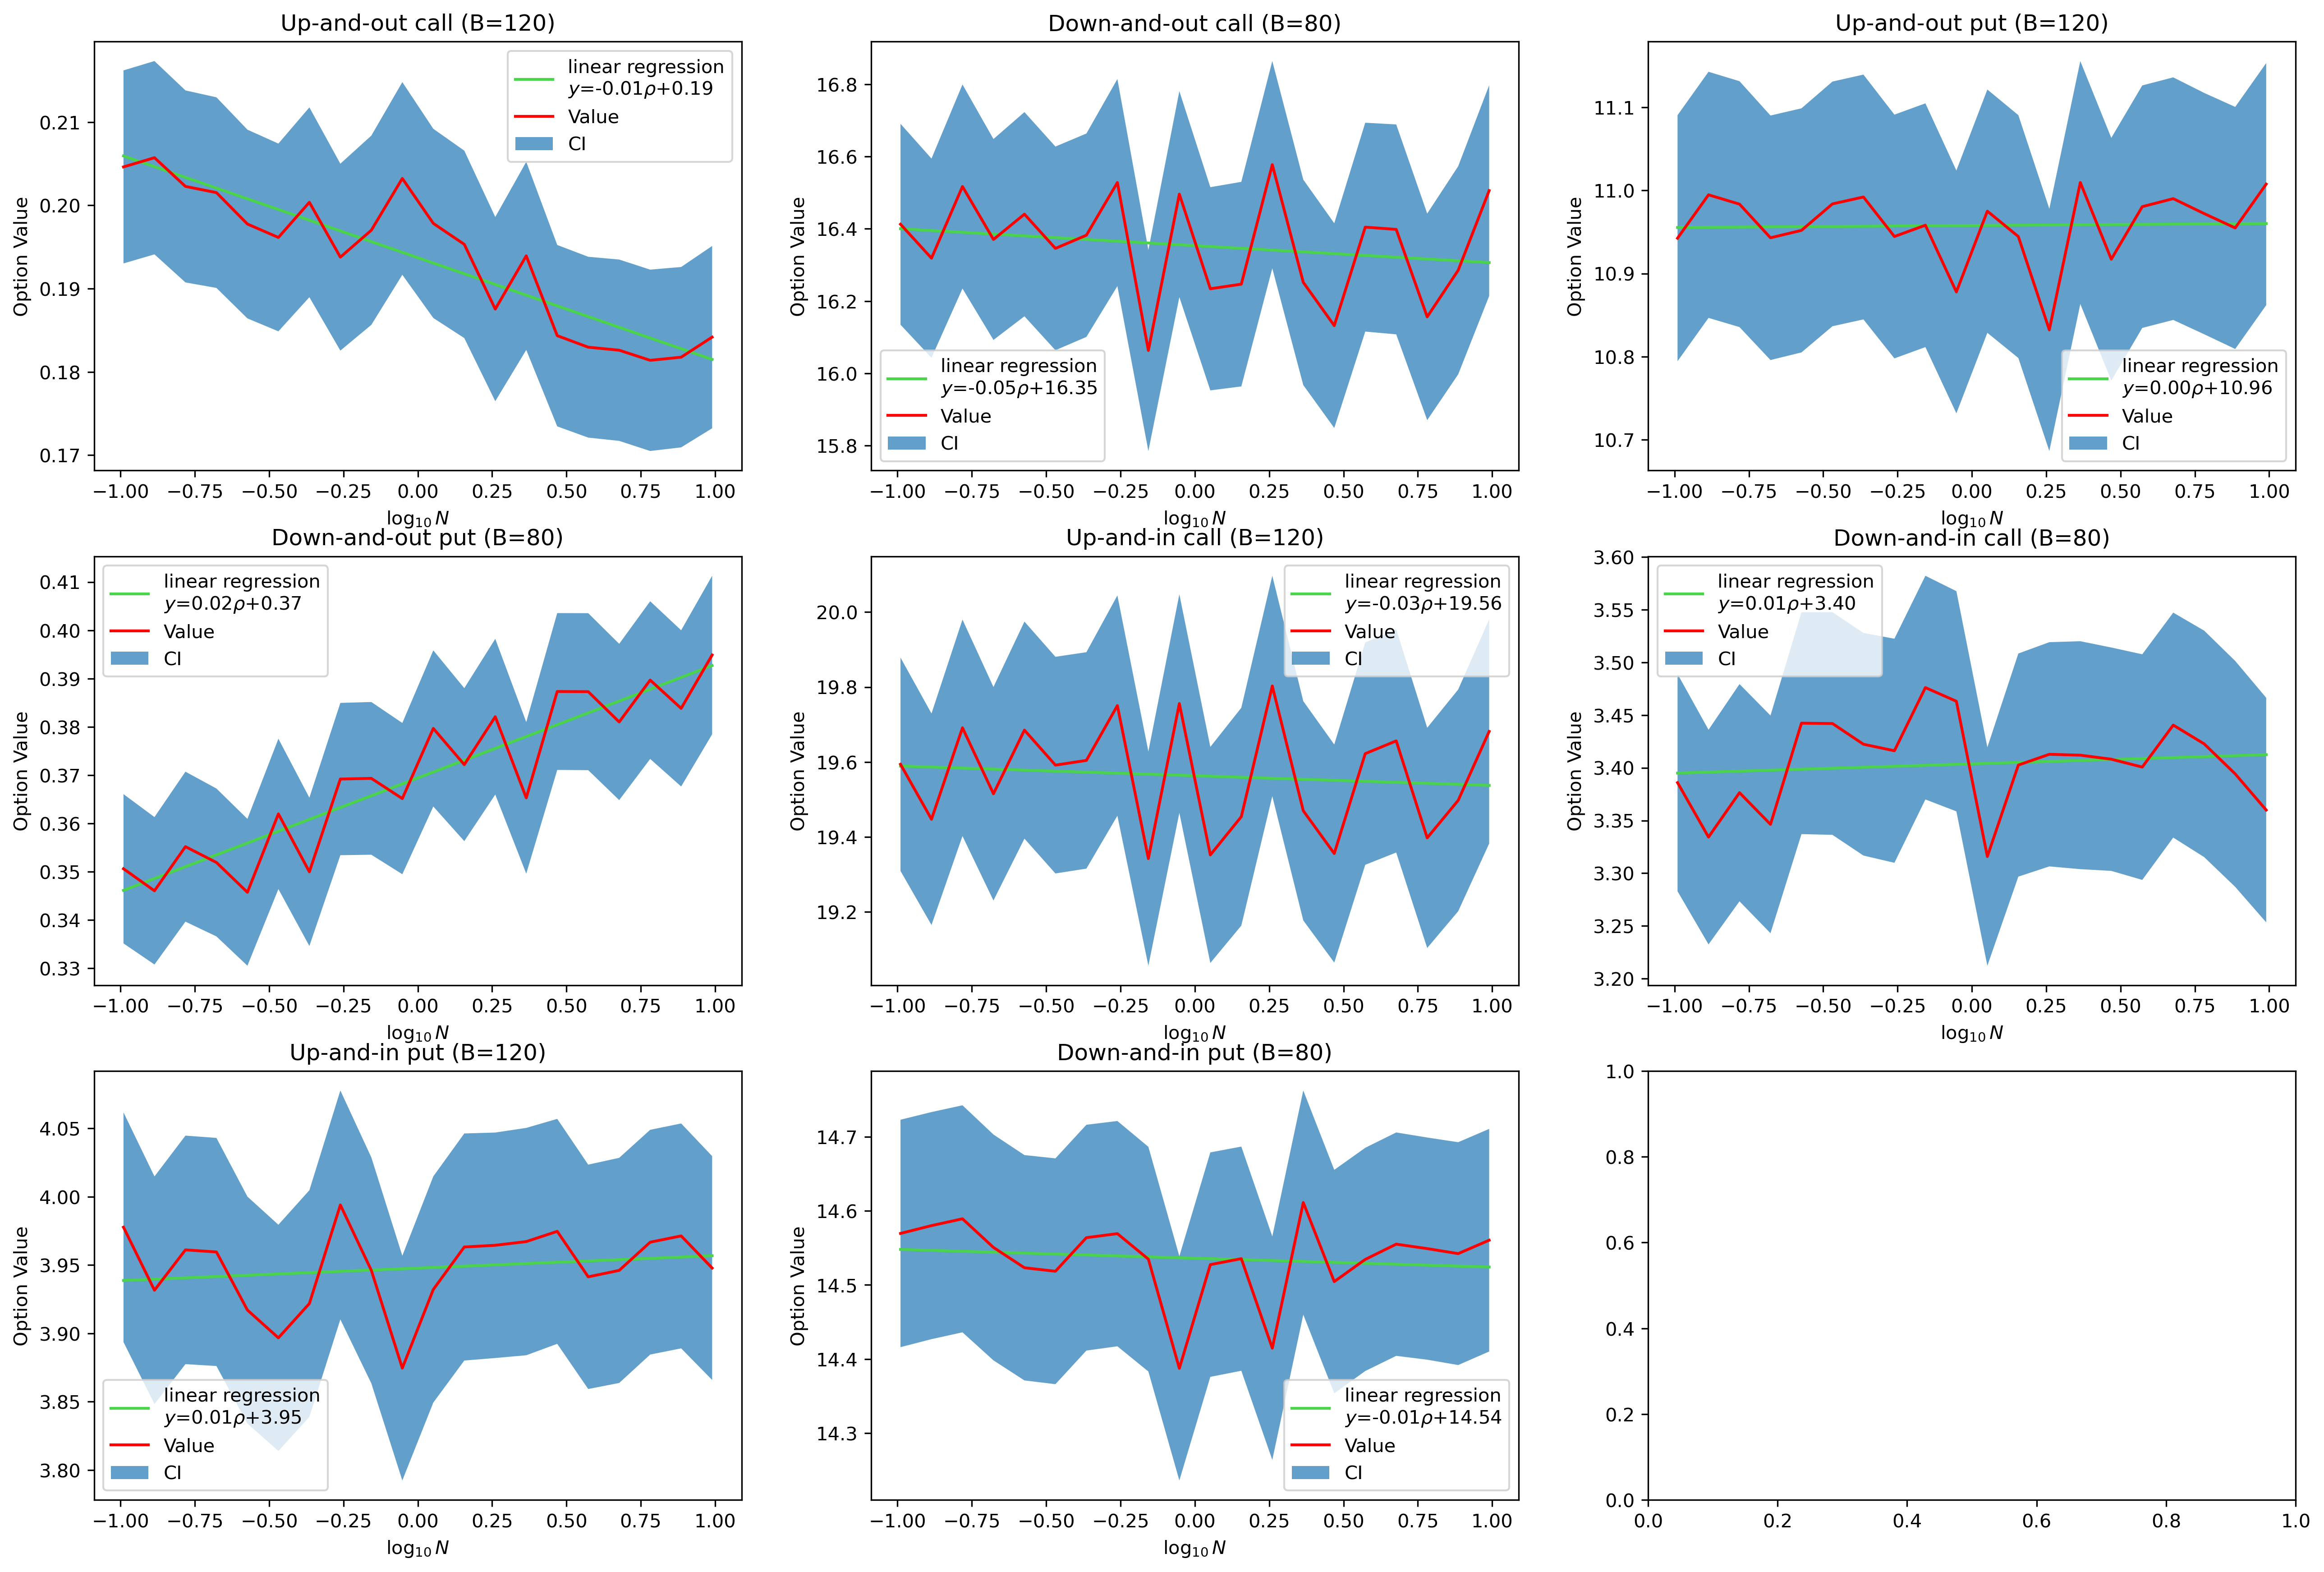

In [23]:
fig, axs = plt.subplots(3,3, figsize=(21, 14), dpi=300)

axs = axs.flatten()

rho = np.linspace(-0.99, 0.99, 20)
for type_str, type_int in option_types.items():
    values = np.asarray(data_lbd_3over2[type_str]['value'])
    upper = np.asarray(data_lbd_3over2[type_str]['upper'])
    lower = np.asarray(data_lbd_3over2[type_str]['lower'])

    b1, b0 = np.polyfit(rho, values, deg=1)
    axs[type_int].plot(rho, b0 + b1 * rho, c="#4bd34b", label=f'linear regression\n$y$={b1:.02f}$\\rho$+{b0:.02f}')

    axs[type_int].plot(rho, values, label='Value', c='r')
    axs[type_int].fill_between(rho, lower, upper, alpha=0.7, label='CI')

    axs[type_int].set_xlabel('$\log_{10} N$')
    axs[type_int].set_ylabel('Option Value')
    axs[type_int].legend()
    axs[type_int].set_title(f'{type_str} (B={120 if type_int % 2 == 0 else 80})')

plt.show()